In [1]:
############################################################################################
# Initialising Flux via Diffusers. If you use other initialisation, just replace this block
############################################################################################


import torch
from optimum.quanto import QTensor
from optimum.quanto import freeze, qfloat8, qint8, quantize

from diffusers import FlowMatchEulerDiscreteScheduler, AutoencoderKL
from diffusers.models.transformers.transformer_flux import FluxTransformer2DModel
from transformers import CLIPTextModel, CLIPTokenizer,T5EncoderModel, T5TokenizerFast

dtype = torch.bfloat16

bfl_repo = "black-forest-labs/FLUX.1-dev"
revision = "refs/pr/3"

token = "hf_[yourhuggingfacetoken]"

text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype, token=token)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype, token=token)
text_encoder_2 = T5EncoderModel.from_pretrained(bfl_repo, subfolder="text_encoder_2", torch_dtype=dtype, revision=revision, token=token)
vae = AutoencoderKL.from_pretrained(bfl_repo, subfolder="vae", torch_dtype=dtype, revision=revision, token=token)
tokenizer_2 = T5TokenizerFast.from_pretrained(bfl_repo, subfolder="tokenizer_2", torch_dtype=dtype, revision=revision, token=token)
scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(bfl_repo, subfolder="scheduler", revision=revision, token=token)
transformer = FluxTransformer2DModel.from_pretrained(bfl_repo, subfolder="transformer", torch_dtype=dtype, revision=revision, token=token)


# quantisation
quantize(transformer, weights=qfloat8)
freeze(transformer)
freeze(text_encoder_2)

/home/kaidu/miniconda3/envs/flux/lib/python3.12/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/kaidu/miniconda3/envs/flux/lib/python3.12/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
############################################################################################
# OPTIONAL: Load Loras (or lycoris or whatever)
# This part seems a bit messy because diffusers lora loading does not work anymore for me
############################################################################################
from peft import LoraConfig
target_modules = [
    "to_k",
    "to_q",
    "to_v",
    "add_k_proj",
    "add_q_proj",
    "add_v_proj",
    "to_out.0",
    "to_add_out",
    "ff.net.0.proj",
    "ff.net.2",
    "ff_context.net.0.proj",
    "ff_context.net.2",
    "proj_mlp",
    "proj_out",
]
transformer_lora_config = LoraConfig(
    r=24,
    lora_alpha=24,
    target_modules=target_modules,
    use_dora=False
)
transformer.add_adapter(transformer_lora_config)

import safetensors.torch
import peft
@torch.no_grad()
def load_lora_weights(dictionary, filename, loraKey="default", use_dora=False):
    additional_keys = set()
    state_dict = safetensors.torch.load_file(filename)
    for prefix, model in dictionary.items():
        lora_layers = {
            (prefix + "." + x): y
            for (x, y) in model.named_modules()
            if isinstance(y, peft.tuners.lora.layer.Linear)
        }
    missing_keys = set(
        [x + ".lora_A.weight" for x in lora_layers.keys()]
        + [x + ".lora_B.weight" for x in lora_layers.keys()]
        + ([x + ".lora_magnitude_vector.weight"] if use_dora else [])
    )
    for k, v in state_dict.items():
        if "lora_A" in k:
            kk = k.replace(".lora_A.weight", "")
            if kk in lora_layers:
                lora_layers[kk].lora_A[loraKey].weight.copy_(v)
                missing_keys.remove(k)
            else:
                additional_keys.add(k)
        elif "lora_B" in k:
            kk = k.replace(".lora_B.weight", "")
            if kk in lora_layers:
                lora_layers[kk].lora_B[loraKey].weight.copy_(v)
                missing_keys.remove(k)
            else:
                additional_keys.add(k)
        elif ".alpha" in k or ".lora_alpha" in k:
            kk = k.replace(".lora_alpha", "").replace(".alpha", "")
            if kk in lora_layers:
                lora_layers[kk].lora_alpha[loraKey] = v
        elif ".lora_magnitude_vector" in k:
            kk = k.replace(".lora_magnitude_vector.weight", "")
            if kk in lora_layers:
                lora_layers[kk].lora_magnitude_vector[loraKey].weight.copy_(v)
                missing_keys.remove(k)
            else:
                additional_keys.add(k)
    return (additional_keys, missing_keys)
addkeys, misskeys = load_lora_weights(
    {"transformer": transformer},
    "/home/kaidu/work/flux/ComfyUI/models/loras/b.safetensors",
    use_dora=False
)

# Attention Processor Injection

So the quick'n dirty solution for me was to inject code into the attention processor that stores the query and key matrices, such that we can compute attention maps afterwards.

The following code is just copy&pasted from diffusers. I just store the keys and queries.

In [3]:
from diffusers.models.embeddings import apply_rotary_emb
from diffusers.models.attention import Attention
from typing import Callable, List, Optional, Tuple, Union
import torch
import torch.nn.functional as F
from torch import nn
class FluxAttnProcessor2_0_HeatMaps:
    """Attention processor used typically in processing the SD3-like self-attention projections."""

    def __init__(self):
        self.query = None
        if not hasattr(F, "scaled_dot_product_attention"):
            raise ImportError("FluxAttnProcessor2_0 requires PyTorch 2.0, to use it, please upgrade PyTorch to 2.0.")

    def __call__(
        self,
        attn: Attention,
        hidden_states: torch.FloatTensor,
        encoder_hidden_states: torch.FloatTensor = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        image_rotary_emb: Optional[torch.Tensor] = None,
    ) -> torch.FloatTensor:
        batch_size, _, _ = hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape

        # `sample` projections.
        query = attn.to_q(hidden_states)
        key = attn.to_k(hidden_states)
        value = attn.to_v(hidden_states)

        inner_dim = key.shape[-1]
        head_dim = inner_dim // attn.heads

        query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
        key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        if attn.norm_q is not None:
            query = attn.norm_q(query)
        if attn.norm_k is not None:
            key = attn.norm_k(key)

        # the attention in FluxSingleTransformerBlock does not use `encoder_hidden_states`
        if encoder_hidden_states is not None:
            # `context` projections.
            encoder_hidden_states_query_proj = attn.add_q_proj(encoder_hidden_states)
            encoder_hidden_states_key_proj = attn.add_k_proj(encoder_hidden_states)
            encoder_hidden_states_value_proj = attn.add_v_proj(encoder_hidden_states)

            encoder_hidden_states_query_proj = encoder_hidden_states_query_proj.view(
                batch_size, -1, attn.heads, head_dim
            ).transpose(1, 2)
            encoder_hidden_states_key_proj = encoder_hidden_states_key_proj.view(
                batch_size, -1, attn.heads, head_dim
            ).transpose(1, 2)
            encoder_hidden_states_value_proj = encoder_hidden_states_value_proj.view(
                batch_size, -1, attn.heads, head_dim
            ).transpose(1, 2)

            if attn.norm_added_q is not None:
                encoder_hidden_states_query_proj = attn.norm_added_q(encoder_hidden_states_query_proj)
            if attn.norm_added_k is not None:
                encoder_hidden_states_key_proj = attn.norm_added_k(encoder_hidden_states_key_proj)

            # attention
            query = torch.cat([encoder_hidden_states_query_proj, query], dim=2)
            key = torch.cat([encoder_hidden_states_key_proj, key], dim=2)
            value = torch.cat([encoder_hidden_states_value_proj, value], dim=2)

        if image_rotary_emb is not None:

            query = apply_rotary_emb(query, image_rotary_emb)
            key = apply_rotary_emb(key, image_rotary_emb)
        saveQuery = False
        ################################################## INJECTED CODE #########################################
        if self.query is None:
            self.query = query.detach().to("cpu")
            self.key = key.detach().to("cpu")
        ###########################################################################################################
        hidden_states = F.scaled_dot_product_attention(query, key, value, dropout_p=0.0, is_causal=False)
        hidden_states = hidden_states.transpose(1, 2).reshape(batch_size, -1, attn.heads * head_dim)
        hidden_states = hidden_states.to(query.dtype)

        if encoder_hidden_states is not None:
            encoder_hidden_states, hidden_states = (
                hidden_states[:, : encoder_hidden_states.shape[1]],
                hidden_states[:, encoder_hidden_states.shape[1] :],
            )
            # linear proj
            hidden_states = attn.to_out[0](hidden_states)
            # dropout
            hidden_states = attn.to_out[1](hidden_states)
            encoder_hidden_states = attn.to_add_out(encoder_hidden_states)

            return hidden_states, encoder_hidden_states
        else:
            return hidden_states


# Attention Maps

In [19]:
import math
class AttentionMaps():

    def __init__(self, pipe):
        self.tokenizer = pipe.tokenizer_2
        self.tokens = self.tokenizer.tokenize(PROMPT)
        self.transformer_blocks = [x for x in pipe.transformer.transformer_blocks if isinstance(x.attn.processor, FluxAttnProcessor2_0_HeatMaps)]

    def visualize_layer(self, layerIndex):
        Q=self.transformer_blocks[layerIndex].attn.processor.query.to("cuda")
        K=self.transformer_blocks[layerIndex].attn.processor.key.to("cuda")
        D = Q.shape[3]
        H = Q.shape[1]
        #rawAttentionMap = (torch.bmm(Q.view(24,-1,128),K.view(24,-1,128).transpose(-1,-2))/np.sqrt(128)).softmax(dim=-1)
        attentionMap = (torch.bmm(Q.view(H,-1,D),K.view(H,-1,D).transpose(-1,-2))/math.sqrt(D)).softmax(dim=-1).mean(dim=0).to("cpu")
        text2text = attentionMap[0:512,0:512]
        img2img = attentionMap[512:,512:]
        textFromimage = attentionMap[0:512,512:].reshape((512,IH//16,IW//16))
        imageFromtext = attentionMap[512:,0:512].reshape((IH//16,IW//16, 512))
        # for now we are only interested in the information flow from prompt to image
        return AttentionMap(imageFromtext, self.tokens, self.tokenizer)

    def visualize_layers(self, layerIndizes):
        amap = None
        count=0
        for layerIndex in layerIndizes:
            layerMap = self.visualize_layer(layerIndex).tensor
            if amap is None:
                amap = layerMap
            else:
                amap += layerMap
            count += 1
        return AttentionMap(amap / count, self.tokens, self.tokenizer)

    def visualize_all_layers(self):
        return self.visualize_layers(range(0,len(self.transformer_blocks)))

import matplotlib.pyplot as plt

class AttentionMap():

    def __init__(self, tensor, tokens, tokenizer):
        self.tensor = tensor
        self.tokens = tokens
        self.tokenizer = tokenizer

    def showTokens(self, tokens):
        plt.imshow(self.getMapForTokens(tokens))
        if isinstance(tokens, str):
            plt.title(tokens)
        else:
            plt.title("|".join(tokens))
        plt.show()

    def showPaddingTokens(self, index):
        plt.imshow(self.getMapForPaddingTokens()[:,:,index])
        plt.title("padding %d" % index)
        plt.show()

    def getMapForTokens(self, tokens):
        if isinstance(tokens, str):
            tokens=(tokens,)
        tokens=[self.tokenizer.tokenize(token) for token in tokens]
        indizes=[]
        buff=[]
        for i in range(0,len(self.tokens)):
            for tok in tokens:
                for j in range(0,len(tok)):
                    if self.tokens[i]!=tok[j]:
                        break
                    else:
                        buff.append(i)
                        i+=1
                    if j==len(tok)-1:
                        indizes += buff
                        buff=[]
                        break
        return self.getMapForTokenIndizes(indizes)

    def getMapForTokenIndex(self, tokenIndex):
        return self.tensor[:,:,tokenIndex].float()

    def getMapForTokenIndizes(self, tokenIndizes):
        return self.tensor[:,:,tokenIndizes].mean(-1).float()

    def getNumberOfPaddingTokens(self):
        return 512-len(self.tokens)

    def getMapForPaddingTokens(self):
        return self.tensor[:,:,len(self.tokens):].float()

# Running a Flux pipeline

Image2Image allows us to control which image we look at and at which step. Downside is that older diffusers version do not have img2img implemented, so you need the up-to-date diffusers from github main branch.

In [5]:
############################################################################################
# We use img2img here so that we can control the image.
# You need the current diffusers (from github main branch) to let it work
############################################################################################
from diffusers.pipelines.flux import FluxImg2ImgPipeline
pipe = FluxImg2ImgPipeline(
    scheduler=scheduler,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    text_encoder_2=text_encoder_2,
    tokenizer_2=tokenizer_2,
    vae=vae,
    transformer=transformer,
)
pipe.enable_model_cpu_offload()

  0%|          | 0/7 [00:00<?, ?it/s]

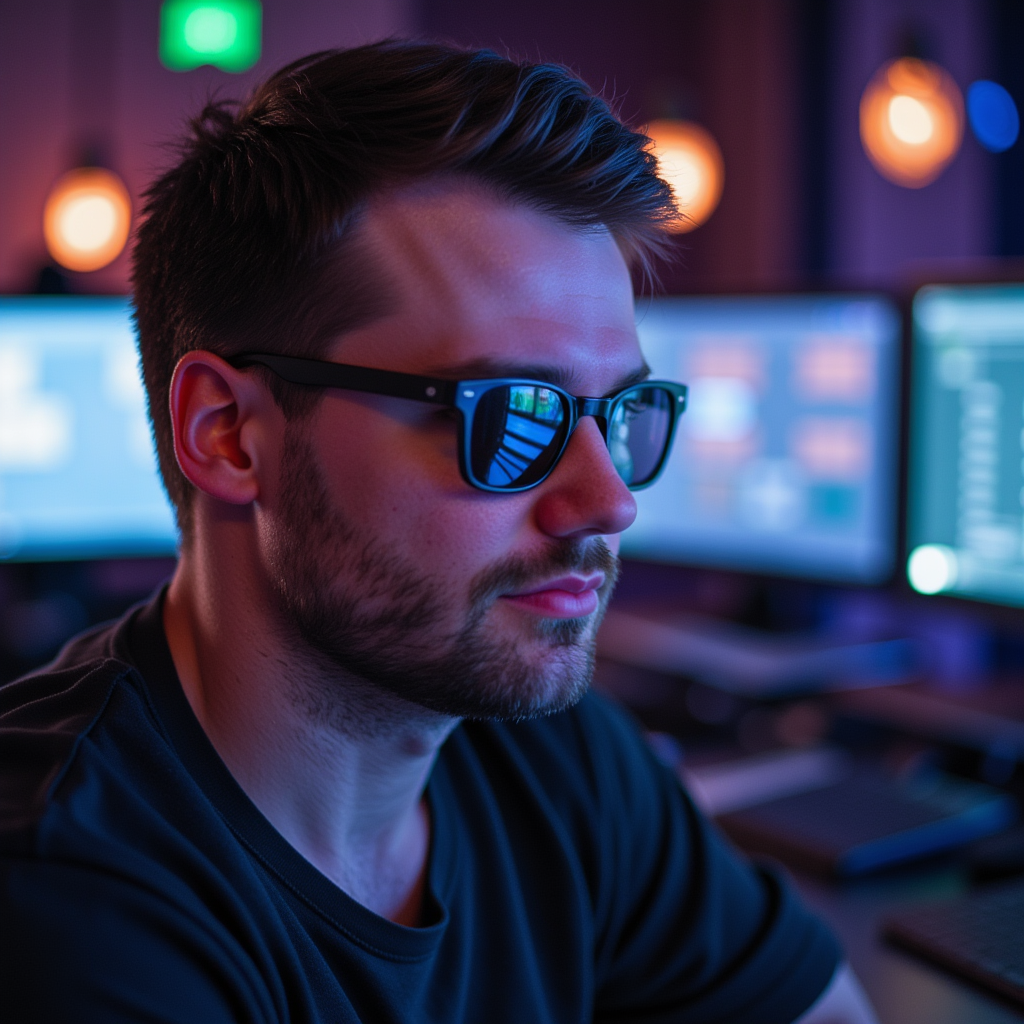

In [6]:
from PIL import Image
# injection, has to be redone for every generation
for block in transformer.transformer_blocks:
    block.attn.processor = FluxAttnProcessor2_0_HeatMaps()

# prompt for img2img
PROMPT="A hacker wearing sun glasses, monitors in background"

# input image for img2img
img = Image.open("example.png").convert("RGB")

# image width and height constants
IW=img.width
IH=img.height

# use strength to control the timestep you look at. Only the first timestep is stored
f=pipe(PROMPT,image=img, guidance_scale=3.5, height=img.height, width=img.width, strength=0.25)
f.images[0]

## Visualize single tokens across all layers

Here we average over all layers. Note that the attention in each layer can differ significantly. In particular, early layers are less precise

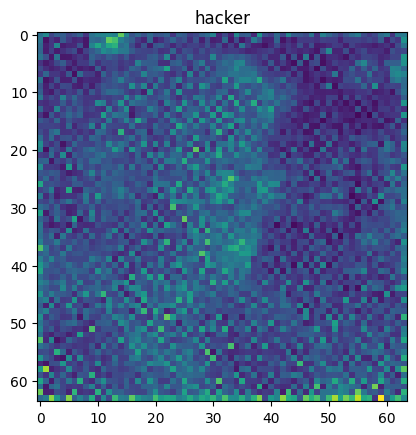

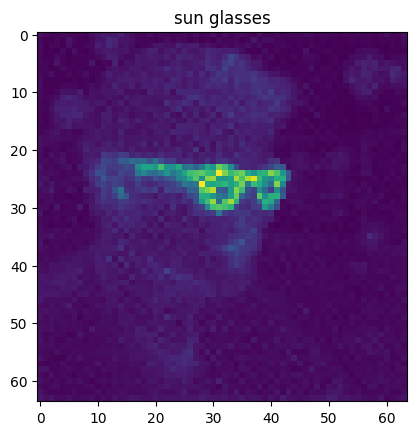

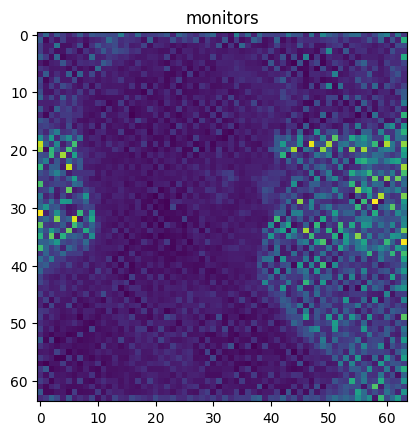

In [10]:
maps = AttentionMaps(pipe)
amap=maps.visualize_all_layers()
for word in ["hacker", "sun glasses", "monitors"]:
    amap.showTokens(word)

## Visualize single token over all layers
Here we visualize a token over all layers, monitoring its change.

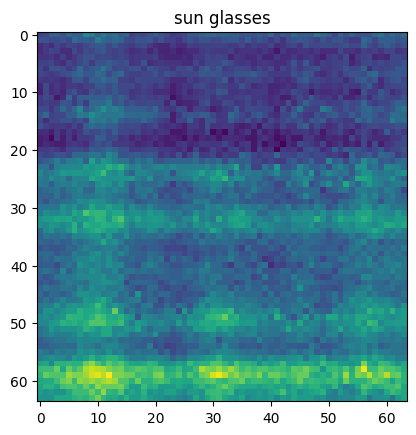

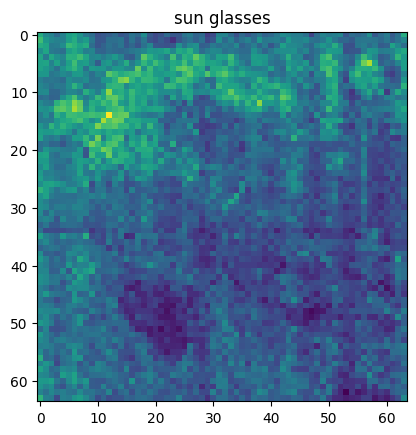

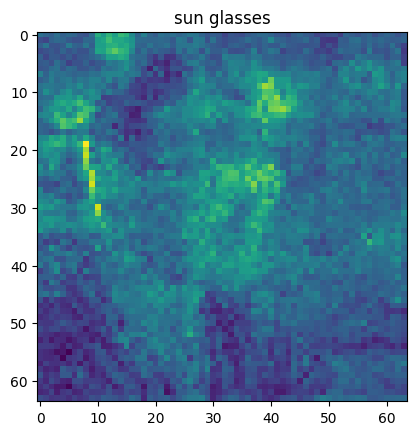

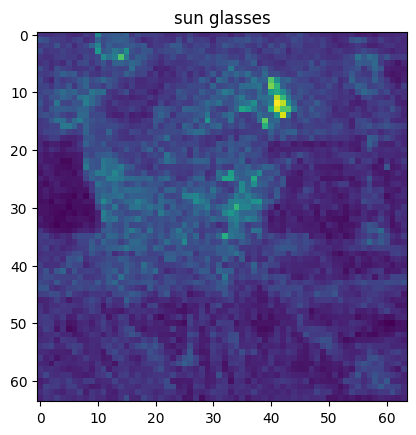

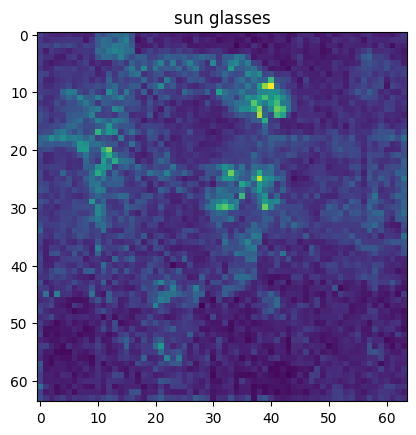

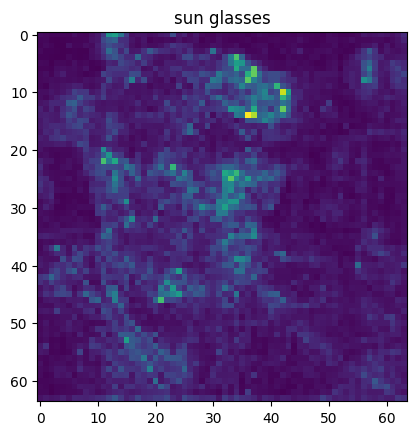

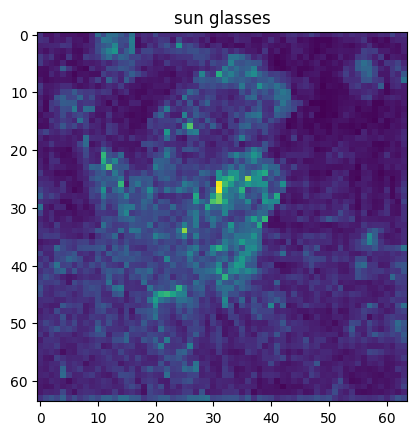

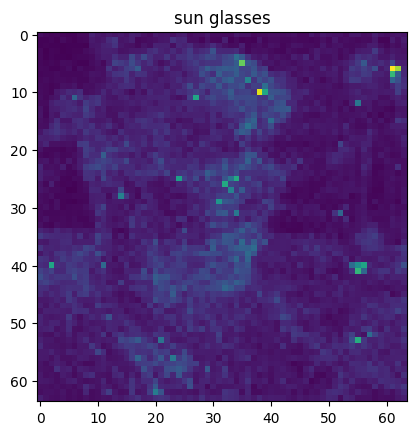

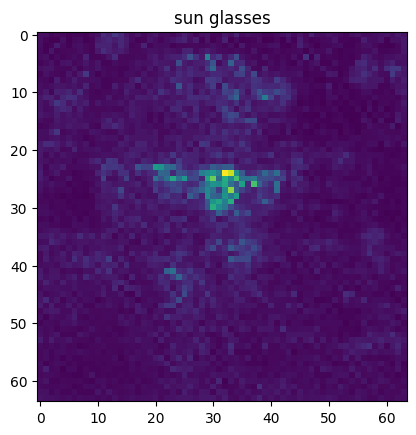

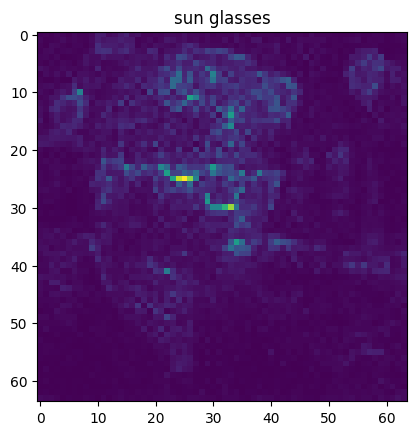

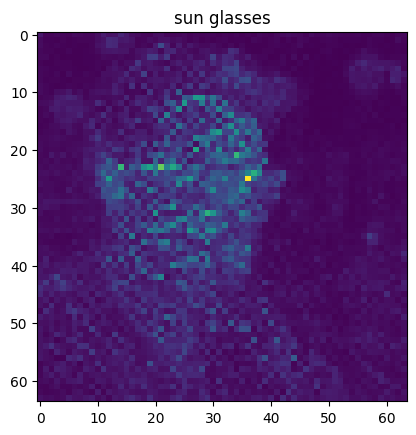

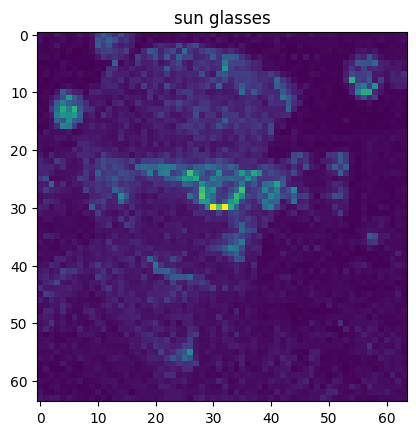

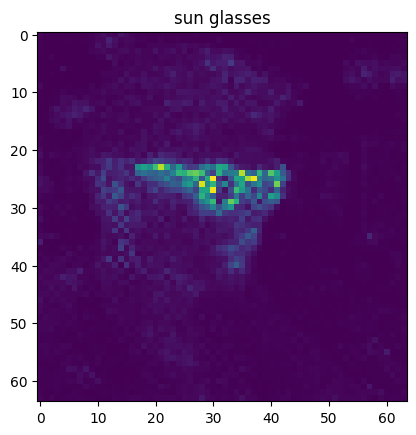

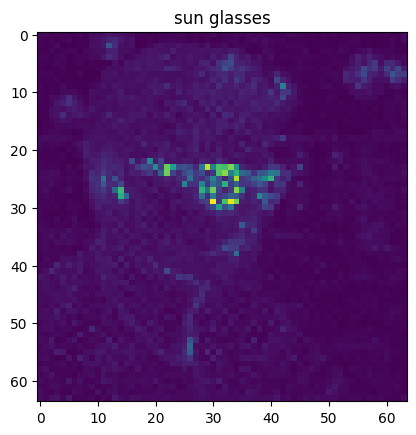

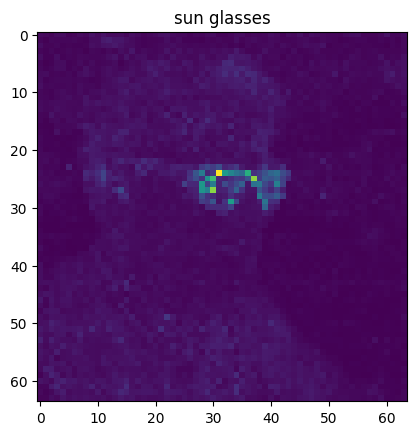

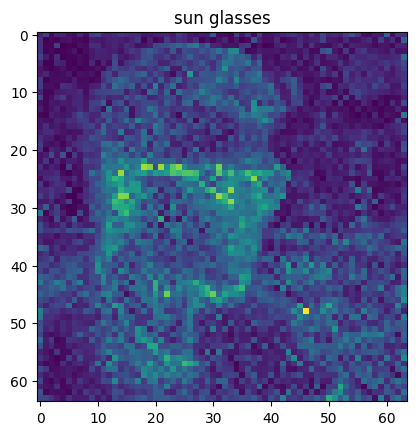

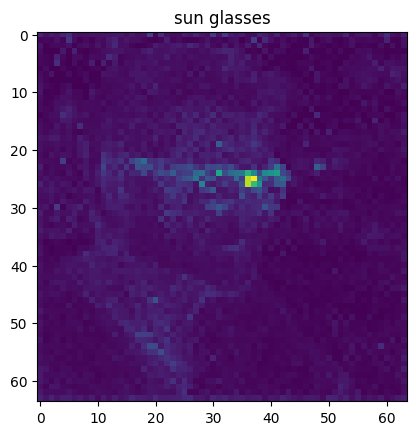

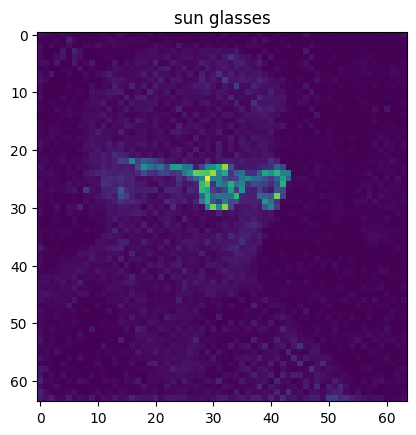

In [11]:
maps = AttentionMaps(pipe)
for layer in range(18):
    maps.visualize_layer(layer).showTokens("sun glasses")

## Visualize padding tokens
Flux is using T5 without attention mask. The maximum length of T5 prompts in Flux is 512 - if a prompt is shorter, the remaining tokens are filled with padding tokens and are used by Flux as e.g. register tokens. When we visualize the attention maps we see that the first few tokens after the prompt are very specific, followed by hundreds of tokens that seem to do nothing. The last few tokens are very specific again. The assumption is that you can remove all these hundreds of intermediate tokens without harming the model as long as you keep the few active ones intact.

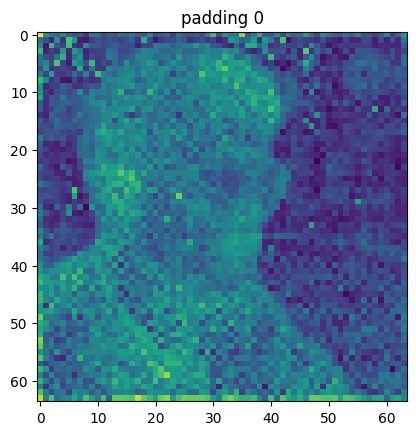

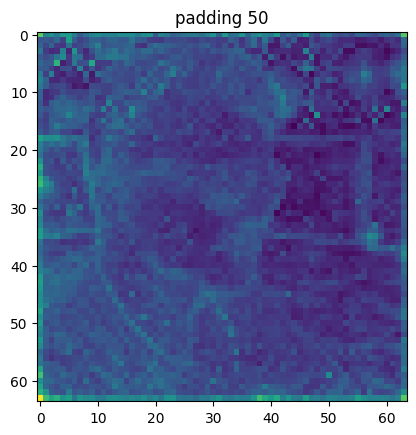

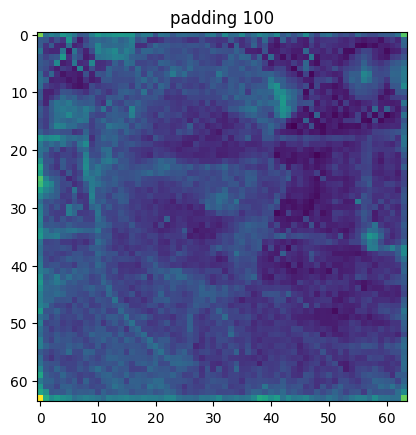

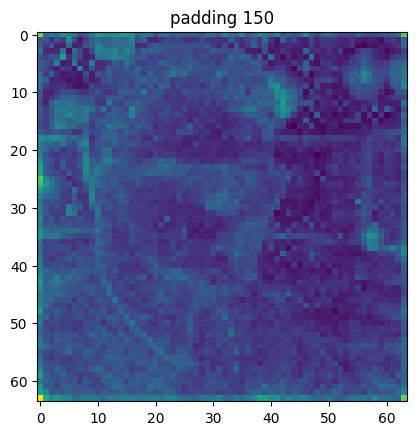

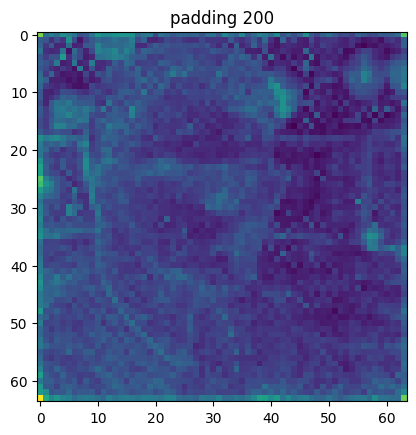

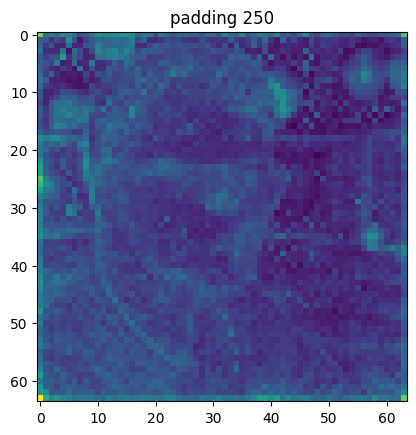

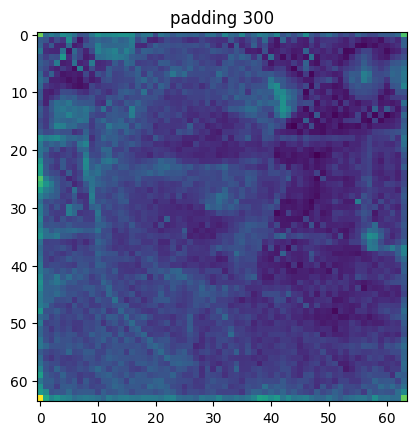

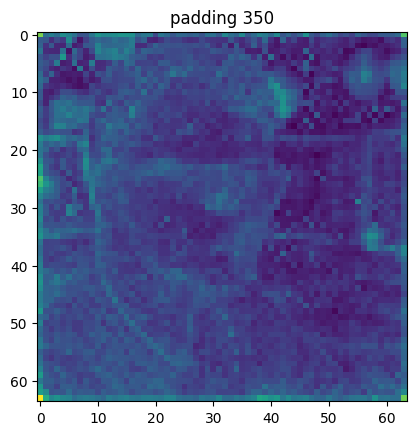

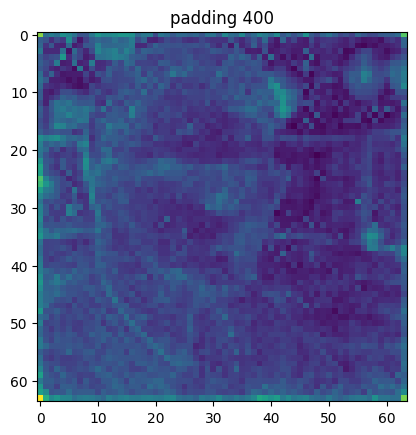

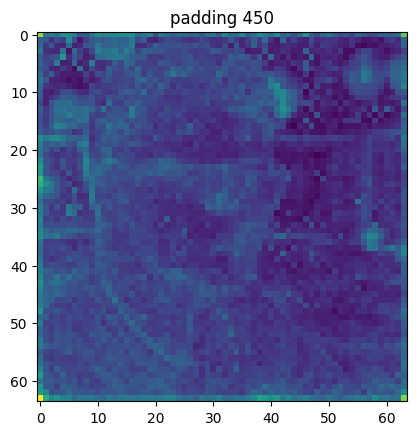

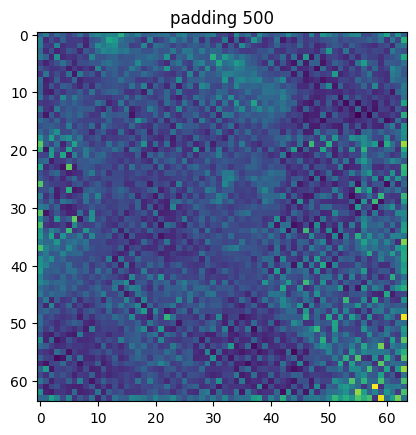

In [21]:
maps = AttentionMaps(pipe)
amap=maps.visualize_all_layers()
for i in range(0, amap.getNumberOfPaddingTokens(), 50):
    amap.showPaddingTokens(i)